<a href="https://colab.research.google.com/github/cda79/IAT360-LLM/blob/main/IAT360_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Required libraries

In [ ]:
!pip install transformers torch datasets

In [ ]:
!pip install transformers torch accelerate

##Data Pre-processing
Convert CSV to huggingface & gpt-2 format

**Import raw .csv data**

In [18]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("/content/shakespeare_dataset_collate.csv", encoding='latin-1')

# display it just to test
print(df.head())
df.info()

                                         shakespeare  \
0  Tis true, and therefore women, being the weake...   
1                                       Fear me not.   
2                            No, marry. I fear thee.   
3  Nay, as they dare. I will bite my thumb at the...   
4                 Do you bite your thumb at us, sir?   

                                              modern  
0  You're right. That's why girls get pushed up a...  
1                              Don't worry about me.  
2                No, really. I am worried about you!  
3  You mean however they dare. I'll bite my thumb...  
4              Hey, are you biting your thumb at us?  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   shakespeare  2605 non-null   object
 1   modern       2604 non-null   object
dtypes: object(2)
memory usage: 40.8+ KB


**Format it for gpt-2**

SOURCE: [Source Text] TARGET: [Target Text] <|endoftext|>

The <|endoftext|> token is for GPT-2 to signal the end of a generated sequence.


In [19]:
def format_translation_data(row):
  # whitespace cleanup
  # Convert to string to handle potential non-string types (like float/NaN)
  shakespeare_text = str(row['shakespeare']).strip()
  modern_text = str(row['modern']).strip()
  formatted_text = f"SOURCE: {shakespeare_text} TARGET: {modern_text} <|endoftext|>"
  return formatted_text

# create new column for collated data to be tokenized
df['text_for_tokenization'] = df.apply(format_translation_data, axis=1)
# display it & check
print(df[['text_for_tokenization']].head())

                               text_for_tokenization
0  SOURCE: Tis true, and therefore women, being t...
1  SOURCE: Fear me not. TARGET: Don't worry about...
2  SOURCE: No, marry. I fear thee. TARGET: No, re...
3  SOURCE: Nay, as they dare. I will bite my thum...
4  SOURCE: Do you bite your thumb at us, sir? TAR...


Full display of the text for double checking since the previous output cuts it out

In [ ]:
# import pandas as pd
# pd.set_option('display.max_colwidth', None)

# print(df[['text_for_tokenization']].to_string())

**Format for the Huggingface trainer**

In [20]:
hf_dataset = Dataset.from_pandas(df)
print("\nConverted to Hugging Face Dataset format.")
print(hf_dataset)


Converted to Hugging Face Dataset format.
Dataset({
    features: ['shakespeare', 'modern', 'text_for_tokenization'],
    num_rows: 2605
})


## Tokenization

**Define the tokenizer & apply**

Default gpt-2 padding & parameters.

To understand how gpt-2 tokenizes the text, [see here.](https://blog.lukesalamone.com/posts/gpt2-tokenization/)

In [21]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling

# gpt-2 tokenizer to make it machine readable
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# default padding token
tokenizer.pad_token = tokenizer.eos_token

# use the huggingface dataset we just converted
# hf_dataset = Dataset.from_pandas(df) << this was done in the previous step

def tokenize_function(examples):
    # uses the prepared 'text_for_tokenization' column
    return tokenizer(
        examples["text_for_tokenization"],
        truncation=True,
        max_length=256,
        padding="max_length"
    )

# apply tokenization
# done by mapping it to the dataset and then removing the columns without tokens
tokenized_datasets = hf_dataset.map(tokenize_function, batched=True, remove_columns=['shakespeare', 'modern', 'text_for_tokenization'])

# Display example tokenized output with the first entry
print("\n dataset structure:")
print(tokenized_datasets)
# where the input is decomposed into a string of numbers or tokens - depending on gpt-2s vocabulary
print(tokenized_datasets[0]["input_ids"])



Map:   0%|          | 0/2605 [00:00<?, ? examples/s]


 dataset structure:
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 2605
})
[47690, 25, 309, 271, 2081, 11, 290, 4361, 1466, 11, 852, 262, 17642, 14891, 11, 389, 1683, 14613, 284, 262, 3355, 13, 8447, 314, 481, 4574, 5575, 2064, 338, 1450, 422, 262, 3355, 11, 290, 14613, 465, 25920, 82, 284, 262, 3355, 13, 309, 46095, 25, 921, 821, 826, 13, 1320, 338, 1521, 4813, 651, 7121, 510, 1028, 7714, 22940, 126, 222, 126, 242, 9930, 821, 4939, 13, 1406, 644, 314, 1183, 466, 318, 4574, 262, 5575, 2064, 1450, 656, 262, 4675, 290, 262, 5575, 2064, 1466, 510, 1028, 262, 3355, 13, 220, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

## Training

In [5]:
train_dataset = tokenized_datasets

# For our purposes, we can train it on all the data. But if we wanted to split the data:
#tokenized_datasets = tokenized_datasets.train_test_split(train_size=0.8, seed=40)

**Load the model and adjust the parameters**

Loading and deploying the gpt-2 model based off tokenized data: https://medium.com/@majd.farah08/generating-text-with-gpt2-in-under-10-lines-of-code-5725a38ea685

Documentation for data collating: https://huggingface.co/docs/transformers/main/main_classes/data_collator

... and what it does internally / the different types: https://towardsdatascience.com/data-collators-in-huggingface-a0c76db798d2/

In [22]:
from transformers import TrainingArguments, Trainer
import torch

# load gpt-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# data collating allows us to use our csv datatables as the input for model
# the mlm specifies whether we should mask tokens or not - usually used for prediction
# when its set to false then the labels = inputs with the padding ignored
# so the whole thing is read AND it returns the labels which is important for our specific translation use
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# set up the trainer and its arguements
training_args = TrainingArguments(
    output_dir="./gpt2_shakespeare_translator",  # directory to save checkpoints
    num_train_epochs=8,                       # epoch size
    per_device_train_batch_size=4,            # batch size - the default is 8 batch size which then goes to 4
    logging_steps=180,                        # log the stats of the training every X amount of steps
)

# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

In [23]:
# training command
trainer.train()

Step,Training Loss
180,3.076600
360,2.839600
540,2.804900
720,2.652800
900,2.345800
1080,2.417700
1260,2.365300
1440,2.156200
1620,2.122200
1800,2.063300


TrainOutput(global_step=5216, training_loss=1.941349793065545, metrics={'train_runtime': 1681.3645, 'train_samples_per_second': 12.395, 'train_steps_per_second': 3.102, 'total_flos': 2722662973440000.0, 'train_loss': 1.941349793065545, 'epoch': 8.0})

####Generate loss training chart for better visualization

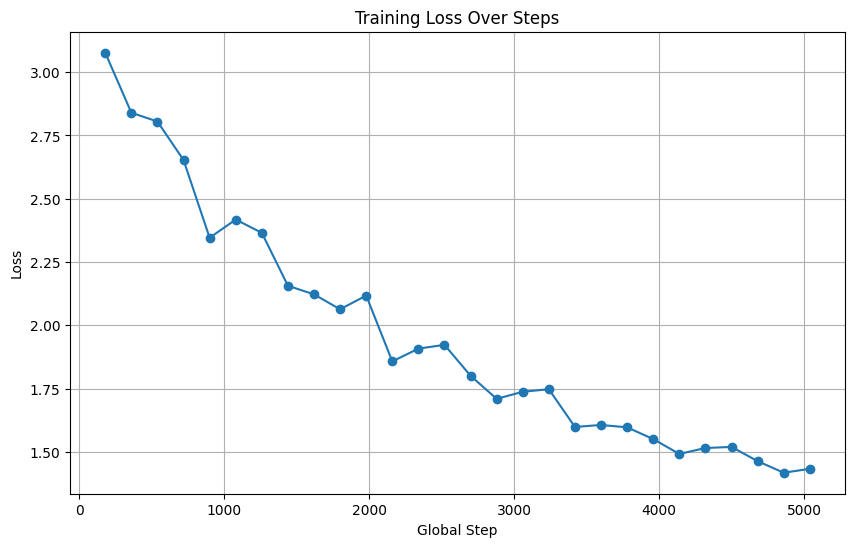

In [24]:
import matplotlib.pyplot as plt

if 'trainer' in locals() or 'trainer' in globals():
    log_history = trainer.state.log_history

    steps = []
    losses = []

    for entry in log_history:
        if 'loss' in entry and 'step' in entry: # Filter for step-wise logs
            steps.append(entry['step'])
            losses.append(entry['loss'])

    if steps and losses:
        plt.figure(figsize=(10, 6))
        plt.plot(steps, losses, marker='o', linestyle='-')
        plt.title('Training Loss Over Steps')
        plt.xlabel('Global Step')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
    else:
        # If no step-wise loss was found, check for the final aggregated training_loss
        final_train_loss_entry = None
        for entry in log_history:
            if 'train_loss' in entry:
                final_train_loss_entry = entry
                break

        if final_train_loss_entry:
            print(f"Only the final training loss is available: {final_train_loss_entry['train_loss']} at step {final_train_loss_entry['step']}.")
            print("A graph requires multiple data points. To see loss progression, ensure 'logging_steps' is set appropriately in TrainingArguments and logs are accessible.")
            # Optionally, plot a single point if that's all there is
            plt.figure(figsize=(2, 2))
            plt.plot([final_train_loss_entry['step']], [final_train_loss_entry['train_loss']], marker='X', color='red', markersize=10)
            plt.title('Final Training Loss')
            plt.xlabel('Global Step')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.show()
        else:
            print("No training loss data found.")
else:
    print("The 'trainer' object was not found.")

###Save newly trained model and reload it to replace the old one

In [25]:
from transformers import GPT2LMHeadModel

# save model
trainer.save_model()
print(f"Model saved to {training_args.output_dir}")

#load it
model = GPT2LMHeadModel.from_pretrained(training_args.output_dir)
print("Trained model reloaded successfully.")

Model saved to ./gpt2_shakespeare_translator
Trained model reloaded successfully.


### Save model as a .zip file (and load it)
So we don't need to retrain it all over again.

In [26]:
import shutil
import os

# Define the name of the zip file (without .zip extension)
zip_file_name = "gpt2_shakespeare_translator_model_slim" # Changed name to indicate slim version
export_dir = "gpt2_shakespeare_translator_slim" # Temporary directory for essential files

# Clean up any previous export directory
if os.path.exists(export_dir):
    shutil.rmtree(export_dir)
os.makedirs(export_dir, exist_ok=True)

try:
    # Save only the essential model files (model weights and config)
    # The 'model' variable here refers to the trained and reloaded model from cell 'b2cedee8'
    model.save_pretrained(export_dir)
    print(f"Model files saved to {export_dir}/")

    # Save only the essential tokenizer files
    # The 'tokenizer' variable here refers to the tokenizer initialized in cell 'gNOZtu1PBDW9'
    tokenizer.save_pretrained(export_dir)
    print(f"Tokenizer files saved to {export_dir}/")

    # Create the zip archive from the export_dir
    archive_path = shutil.make_archive(zip_file_name, 'zip', export_dir)
    print(f"Slim model successfully saved as a zip file: {archive_path}")

except Exception as e:
    print(f"Error during saving or zipping: {e}")
finally:
    # Clean up the temporary export directory
    if os.path.exists(export_dir):
        shutil.rmtree(export_dir)
        print(f"Cleaned up temporary directory: {export_dir}")

Model files saved to gpt2_shakespeare_translator_slim/
Tokenizer files saved to gpt2_shakespeare_translator_slim/
Slim model successfully saved as a zip file: /content/gpt2_shakespeare_translator_model_slim.zip
Cleaned up temporary directory: gpt2_shakespeare_translator_slim


#### Load Saved Model


In [ ]:
import zipfile
import os
from transformers import GPT2Tokenizer, GPT2LMHeadModel

zip_file_name = "gpt2_shakespeare_translator_model_slim.zip"
model_dir = "gpt2_shakespeare_translator_slim"

# Unzip the model if it's not already extracted
if not os.path.exists(model_dir):
    if os.path.exists(zip_file_name):
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall(".")
        print(f"'{zip_file_name}' extracted to '{model_dir}/'")
    else:
        print(f"Error: Zip file '{zip_file_name}' not found. Please ensure it's in the current directory.")
else:
    print(f"Model directory '{model_dir}/' already exists. Skipping extraction.")

# Load the tokenizer and model
if os.path.exists(model_dir):
    loaded_tokenizer = GPT2Tokenizer.from_pretrained(model_dir)
    loaded_model = GPT2LMHeadModel.from_pretrained(model_dir)
    print("Trained model and tokenizer loaded successfully!")
else:
    print("Cannot load model: Model directory not found after attempted extraction.")

**Generate loss training chart for better visualization**

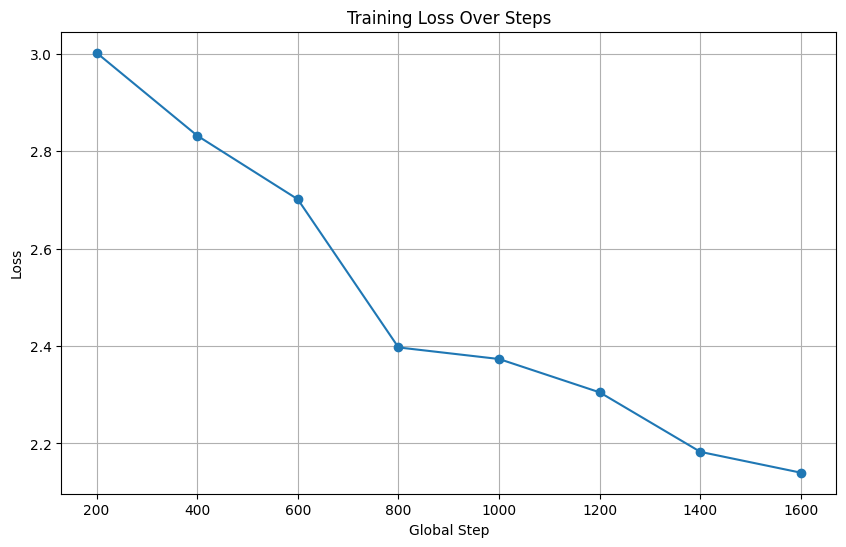

In [ ]:
import matplotlib.pyplot as plt

if 'trainer' in locals() or 'trainer' in globals():
    log_history = trainer.state.log_history

    steps = []
    losses = []

    for entry in log_history:
        if 'loss' in entry and 'step' in entry: # Filter for step-wise logs
            steps.append(entry['step'])
            losses.append(entry['loss'])

    if steps and losses:
        plt.figure(figsize=(10, 6))
        plt.plot(steps, losses, marker='o', linestyle='-')
        plt.title('Training Loss Over Steps')
        plt.xlabel('Global Step')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
    else:
        # If no step-wise loss was found, check for the final aggregated training_loss
        final_train_loss_entry = None
        for entry in log_history:
            if 'train_loss' in entry:
                final_train_loss_entry = entry
                break

        if final_train_loss_entry:
            print(f"Only the final training loss is available: {final_train_loss_entry['train_loss']} at step {final_train_loss_entry['step']}.")
            print("A graph requires multiple data points. To see loss progression, ensure 'logging_steps' is set appropriately in TrainingArguments and logs are accessible.")
            # Optionally, plot a single point if that's all there is
            plt.figure(figsize=(2, 2))
            plt.plot([final_train_loss_entry['step']], [final_train_loss_entry['train_loss']], marker='X', color='red', markersize=10)
            plt.title('Final Training Loss')
            plt.xlabel('Global Step')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.show()
        else:
            print("No training loss data found.")
else:
    print("The 'trainer' object was not found.")

## Generate Text

Test model by using custom inputs and reviewing the outputs based on training.

###**Important**
the input sentence must end w/ "TARGET:" so the model can generate its response afterwards. This is how it tries to complete the entire sentence based off the patterns learned during training.


*   Where we formatted and collated the sentences to start with `SOURCE` and `TARGET` from before:
*   `formatted_text = f"SOURCE: {shakespeare_text} TARGET: {modern_text} <|endoftext|>"`




Generation part of the code and its parameters were based off the huggingface text documentation: https://huggingface.co/docs/transformers/en/main_classes/text_generation

as well as gemini's suggestions for what should be fine tuned

In [ ]:
from transformers import pipeline

# huggingface pipeline library
generator = pipeline(
    'text-generation', # task
    model=model, # saved model
    tokenizer=tokenizer, # use previous established tokenizer
    device=0 if torch.cuda.is_available() else -1 # Use GPU if available
)

while True:
   ## INPUT PART !!!
    input_shakespeare = input("Enter a Shakespearean phrase to translate (or type 'QUIT' to exit): ")
   # EXIT while-loop
    if input_shakespeare.strip().upper() == 'QUIT':
        print("Exiting translator. Goodbye!")
        break

    # Format the prompt for the generator
    prompt = f"SOURCE: {input_shakespeare} TARGET:"

    ## generator parameters
    output = generator(
        prompt,
        max_new_tokens=30,
        num_return_sequences=1,
        do_sample=True,
        top_k=50,
        temperature=0.7,
        eos_token_id=tokenizer.eos_token_id
    )

    ## generated text extraction + stripping + cleaning
    generated_text = output[0]['generated_text']
    # remove the PROMPT: text from the generated line and the end <|endoftext|> token
    translation = generated_text.replace(prompt, '').replace(tokenizer.eos_token, '').strip()

    ## FINAL OUTPUT
    print(f"\n--- Translation Output ---")
    print(f"Input Prompt: {input_shakespeare}")
    print(f"Generated Modern English: {translation}\n")

##Push model to Huggingface hub

In [ ]:
!huggingface-cli login

In [31]:
model.push_to_hub(repo_id="gpt2-shakespeare-translator")
tokenizer.push_to_hub(repo_id="gpt2-shakespeare-translator")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...o7tpnt9/model.safetensors:   7%|6         | 33.6MB /  498MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/cda79/gpt2-shakespeare-translator/commit/867847f9b47fc306a4fd9b095e701c1aa68fcd78', commit_message='Upload tokenizer', commit_description='', oid='867847f9b47fc306a4fd9b095e701c1aa68fcd78', pr_url=None, repo_url=RepoUrl('https://huggingface.co/cda79/gpt2-shakespeare-translator', endpoint='https://huggingface.co', repo_type='model', repo_id='cda79/gpt2-shakespeare-translator'), pr_revision=None, pr_num=None)